In [2]:
import fitbit
import ConfigParser
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os.path
from tqdm import tqdm
from scipy import signal

np.random.seed(sum(map(ord, "aesthetics")))

In [3]:
#Load Settings
parser = ConfigParser.SafeConfigParser()
parser.read('config.ini')
CI_id              = parser.get('Login Parameters', 'CLIENT_ID')
CI_client_secret   = parser.get('Login Parameters', 'CLIENT_SECRET')
CI_access_token    = parser.get('Login Parameters', 'ACCESS_TOKEN')
CI_refresh_token   = parser.get('Login Parameters', 'REFRESH_TOKEN')

authd_client = fitbit.Fitbit(CI_id, CI_client_secret, 
                             oauth2=True, access_token=CI_access_token, 
                             refresh_token=CI_refresh_token)

# first day with the fitbit surge
base_date = '2017-04-29'
today = '2017-08-03'

start = datetime.datetime.strptime(base_date, "%Y-%m-%d")
end = datetime.datetime.strptime(today, "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

In [4]:
# ## Save the data

# for date in date_generated:
#     output_file = 'output/'+date.strftime("%Y-%m-%d")+'_datadumpHeart.json'
#     if os.path.isfile(output_file):
#         print(output_file, 'exists, skipping.')
#         pass 
#     else:
#         f = open(output_file, 'w')
#         intradayH = authd_client.intraday_time_series('activities/heart', 
#             base_date = date.strftime("%Y-%m-%d"), 
#             detail_level = '1sec', start_time = None, end_time = None)

#         print(date.strftime("%Y-%m-%d"), 'numRec', 
#               len(intradayH['activities-heart-intraday']['dataset']))
#         json.dump(intradayH, f)
#         f.close()

In [74]:
# get a list of files from the output directory
all_data = {}
all_data_resamp = {}
resample_to_n_samples = 1440
for date in tqdm(date_generated):
    output_file = open('output/'+date.strftime("%Y-%m-%d")+'_datadumpHeart.json', 'r')
    data = json.load(output_file)
    l = data['activities-heart-intraday']['dataset']
    all_data[date.strftime("%Y-%m-%d")] = [d['value'] for d in l]
    all_data_resamp[date.strftime("%Y-%m-%d")] = signal.resample([d['value'] for d in l], 
        resample_to_n_samples)

100%|██████████| 96/96 [00:05<00:00, 23.92it/s]


In [75]:
# dataframe the resampled data
df = pd.DataFrame.from_dict(all_data_resamp)

# chop things up into weekdays and weekends 
df_sat = df[df.columns[::7]]
df_sun = df[df.columns[1::7]]
df_mon = df[df.columns[2::7]]
df_tue = df[df.columns[3::7]]
df_wed = df[df.columns[4::7]]
df_thu = df[df.columns[5::7]]
df_fri = df[df.columns[6::7]]

df_wknd = pd.concat([df_sat, df_sun], axis=1)
df_wkdy = pd.concat([df_mon, df_tue, df_wed, df_thu, df_fri], axis=1)

In [76]:
num_wknd = df_wknd.shape[1]
num_wkdy = df_wkdy.shape[1]

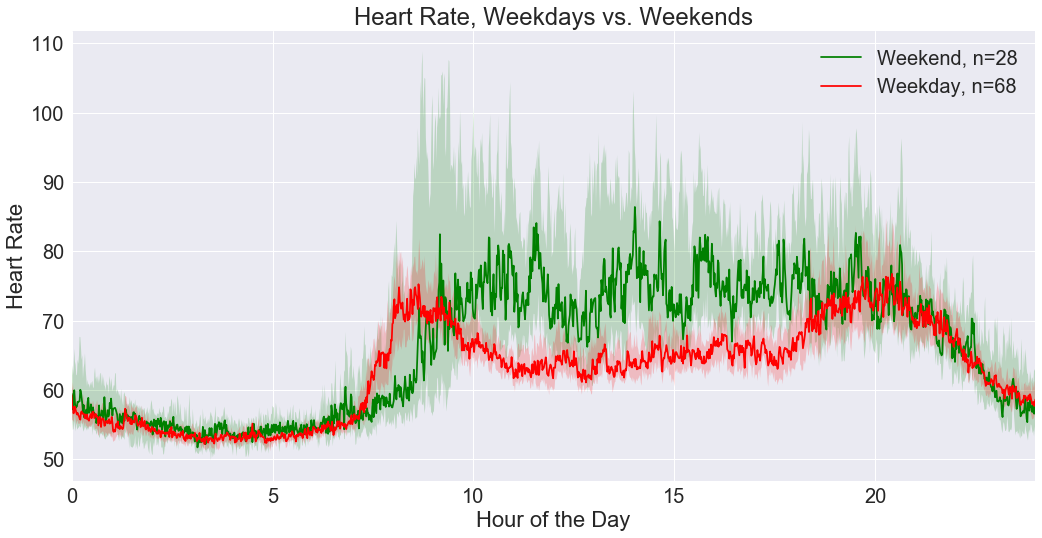

In [77]:
# plot the mean and standard error of the mean for weekdays and weekends
sns.set(font_scale=2)  # crazy big
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.set_title('Heart Rate, Weekdays vs. Weekends')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Heart Rate')
ax.set_xlim(0, 24)

hours = np.linspace(0, 24, resample_to_n_samples, endpoint=False)
sns.tsplot(data=np.transpose(df_wknd.as_matrix()), estimator=np.median, time=hours, 
           ax=ax, color='green', ci=[95], legend=True, condition='Weekend, n={}'.format(num_wknd))
sns.tsplot(data=np.transpose(df_wkdy.as_matrix()), estimator=np.median, time=hours, 
           ax=ax, color='red', ci=[95], legend=True, condition='Weekday, n={}'.format(num_wkdy))

plt.tight_layout()

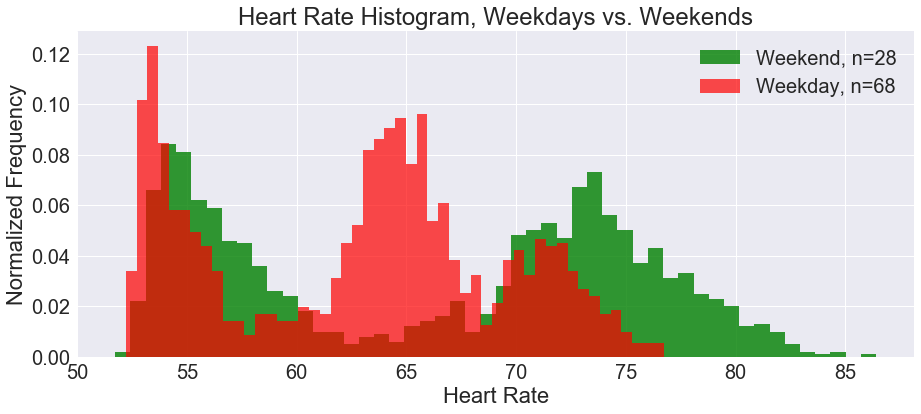

In [78]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.set_title('Heart Rate Histogram, Weekdays vs. Weekends')
ax.set_xlabel('Heart Rate')
ax.set_ylabel('Normalized Frequency')
df_wknd.median(axis=1).hist(bins=50, alpha=0.8, color='green', normed=True)
df_wkdy.median(axis=1).hist(bins=50, alpha=0.7, color='red', normed=True)
plt.legend(['Weekend, n={}'.format(num_wknd), 'Weekday, n={}'.format(num_wkdy)])

In [ ]:
### NOTES
# number of rows in the series 
# print(len(all_data))

# predicting day of the week from physical activity
# aggregate statistics

fig, axes = plt.subplots(nrows=len(all_data), ncols=1, sharey=True, figsize=(12,len(all_data)))

ax_idx = 0
min_len = 1e9
max_len = 0
for k,v in all_data.iteritems():
    if len(v) > max_len:
        max_len = len(v)
    if len(v) < min_len:
        min_len = len(v)
        
    axes[ax_idx].plot(v)
    ax_idx += 1
plt.tight_layout()

# subsample and downsample to the smallest bins
print('min_len', min_len, 'max_len', max_len)

y = all_data[base_date]
x = np.linspace(0, 24, len(y), endpoint=False)
f = signal.resample(y, 24*60)
xnew = np.linspace(0, 24, len(f), endpoint=False)
fig = plt.figure(figsize=(15,6))
plt.plot(x, y, '-', xnew, f, 'g.')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

y = all_data['2017-08-02']
x = np.linspace(0, 24, len(y), endpoint=False)
f = signal.resample(y, 24*60)
xnew = np.linspace(0, 24, len(f), endpoint=False)
fig = plt.figure(figsize=(15,6))
plt.plot(x, y, '-', xnew, f, 'g.')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

sns.set(font_scale=2)  # crazy big
fig = plt.figure(figsize=(15,6))
y = df.mean(axis=1)
x = np.linspace(0, 24, len(y), endpoint=False)
e = df.std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-e, y+e, alpha=0.2)